# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import random
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from gensim.models import Word2Vec
%matplotlib inline


# Read Data

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)

In [3]:
DATASET_COLUMNS=['target','ids','date','query','user','text']
df = pd.read_csv('twitter_depression_data.csv' , names=DATASET_COLUMNS,encoding='latin-1')
df.head()

,target,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


# Data Description

In [4]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [5]:
df['target'] = df['target'].replace(4,1)

Negative    800000
Positive    800000
Name: target, dtype: int64


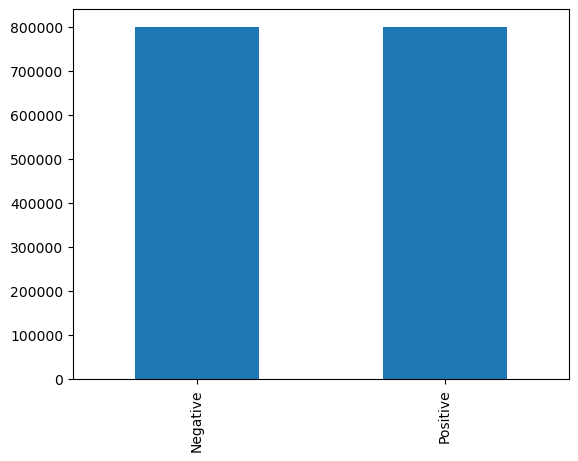

In [6]:
sentiment = {0:"Negative", 1:"Positive"}
print(df.target.apply(lambda x: sentiment[x]).value_counts())
df.target.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

In [7]:
##data_pos=df[df['target']==0]
#data_neg=df[df['target']==1]
#data_pos=data_pos.iloc[:int(11631)]
#data_neg=data_neg.iloc[:int(23197)]
#dataset=pd.concat([data_pos,data_neg])
#print(len(dataset))
#dataset.head(10)
#11631
#23197

In [8]:
dataset=df[['target','text']]
dataset

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...,...
1599995,1,Just woke up. Having no school is the best feeling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,1,Are you ready for your MoJo Makeover? Ask me for details
1599998,1,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


# Text Preprocessing

1.Cleaning Text

2.Text Analzye

 3.Word Cloud Map

In [9]:
# Converting to Lower case

dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

1599995                          just woke up. having no school is the best feeling ever 
1599996    thewdb.com - very cool to hear old walt interviews!  â« http://blip.fm/~8bmta
1599997                         are you ready for your mojo makeover? ask me for details 
1599998                 happy 38th birthday to my boo of alll time!!! tupac amaru shakur 
1599999                    happy #charitytuesday @thenspcc @sparkscharity @speakinguph4h 
Name: text, dtype: object

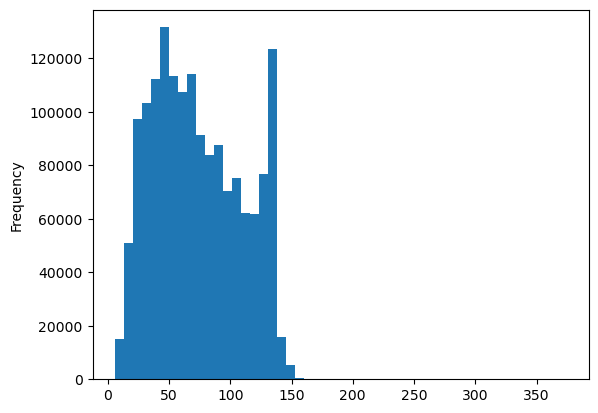

In [10]:
dataset['text'].str.len().plot(bins=50, kind='hist');

In [11]:
# Defining stopwords

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
# Removing Stopwords

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

1599995                                     woke up. no school best feeling ever
1599996    thewdb.com - cool hear old walt interviews! â« http://blip.fm/~8bmta
1599997                                         ready mojo makeover? ask details
1599998                  happy 38th birthday boo alll time!!! tupac amaru shakur
1599999            happy #charitytuesday @thenspcc @sparkscharity @speakinguph4h
Name: text, dtype: object

In [13]:
# Removing stop words using nltk lib

#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

NLTK stop word lists 

{'couldn', 'it', "aren't", 'whom', 'doing', 'has', 'll', 'her', 'hasn', 'are', 'or', 'his', 'not', 'its', 'theirs', 'then', "you'd", 't', 'hadn', 'we', 'all', 'him', 'those', 'with', 'any', "weren't", 'mustn', 'here', 's', 'a', 'only', 'the', 'so', 'just', 'weren', "don't", 've', "haven't", 'against', 'didn', 'when', 'for', 'no', 'having', 'below', 'where', 'aren', 'itself', 'too', 'nor', 'doesn', 'me', 'have', 'at', 'other', 'out', 'they', 'which', 'been', 'this', 'do', 'more', 'was', 'if', 'what', 'during', 'can', 'mightn', 'she', 'had', 'yourself', 'who', 'both', 'am', 'themselves', 'before', 'down', "shouldn't", 'yourselves', 'on', 'most', "that'll", 'some', 'own', 'above', 'i', 'them', "you're", 'be', 'through', 'wasn', 'between', 'in', 'being', 'y', 'is', 'each', "she's", 'further', 'after', 'that', 'because', 'such', "mustn't", 'you', 'ourselves', 'by', 'and', 'himself', 'o', 'of', 'shan', "couldn't", 'shouldn', 'these', 'under', 'm', "you'll", 'ours', 'in

In [14]:
dataset['text']=dataset['text'].apply(remove_stopwords)
dataset['text'].tail()

1599995                                         woke up. school best feeling ever
1599996    thewdb.com - cool hear old walt interviews ! â« http://blip.fm/~8bmta
1599997                                         ready mojo makeover ? ask details
1599998                happy 38th birthday boo alll time ! ! ! tupac amaru shakur
1599999             happy #charitytuesday @thenspcc @sparkscharity @speakinguph4h
Name: text, dtype: object

In [15]:
# removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

0                               @switchfoot  shoulda got david carr third day it. ;
1    upset ' update facebook texting ... might cry result school today also. blah !
2                 @kenichan dived many times ball. managed save 50 % rest go bounds
3                                                  whole body feels itchy like fire
4                               @nationwideclass , ' behaving all. ' mad. ? ' see .
Name: text, dtype: object

In [16]:
# removing numbers 

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

0                               @switchfoot  shoulda got david carr third day it. ;
1    upset ' update facebook texting ... might cry result school today also. blah !
2                   @kenichan dived many times ball. managed save  % rest go bounds
3                                                  whole body feels itchy like fire
4                               @nationwideclass , ' behaving all. ' mad. ? ' see .
Name: text, dtype: object

In [17]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [18]:
# remove twitter handles (@user)

dataset['text'] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset.head()

,target,text
0,0,shoulda got david carr third day it. ;
1,0,upset ' update facebook texting ... might cry result school today also. blah !
2,0,dived many times ball. managed save % rest go bounds
3,0,whole body feels itchy like fire
4,0,", ' behaving all. ' mad. ? ' see ."


In [19]:
# remove special characters, numbers and punctuations

dataset['text'] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head()

C:\Users\Samel Store\AppData\Local\Temp\ipykernel_760\409435215.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['text'] = dataset['text'].str.replace("[^a-zA-Z#]", " ")


,target,text
0,0,shoulda got david carr third day it
1,0,upset update facebook texting might cry result school today also blah
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,behaving all mad see


In [20]:
# remove short words

dataset['text'] = dataset['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
dataset.head()

,target,text
0,0,shoulda david carr third
1,0,upset update facebook texting might result school today also blah
2,0,dived many times ball managed save rest bounds
3,0,whole body feels itchy like fire
4,0,behaving


In [21]:
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

0                                                   [shoulda, david, carr, third]
1    [upset, update, facebook, texting, might, result, school, today, also, blah]
2                         [dived, many, times, ball, managed, save, rest, bounds]
3                                         [whole, body, feels, itchy, like, fire]
4                                                                      [behaving]
Name: text, dtype: object

In [22]:
# Applying Stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

0                                                   [shoulda, david, carr, third]
1    [upset, update, facebook, texting, might, result, school, today, also, blah]
2                         [dived, many, times, ball, managed, save, rest, bounds]
3                                         [whole, body, feels, itchy, like, fire]
4                                                                      [behaving]
Name: text, dtype: object

In [23]:
# Applying Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' ' .join(text)
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset.head()

[nltk_data] Downloading package wordnet to C:\Users\Samel
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Samel
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,target,text
0,0,shoulda david carr third
1,0,upset update facebook texting might result school today also blah
2,0,dived many time ball managed save rest bound
3,0,whole body feel itchy like fire
4,0,behaving


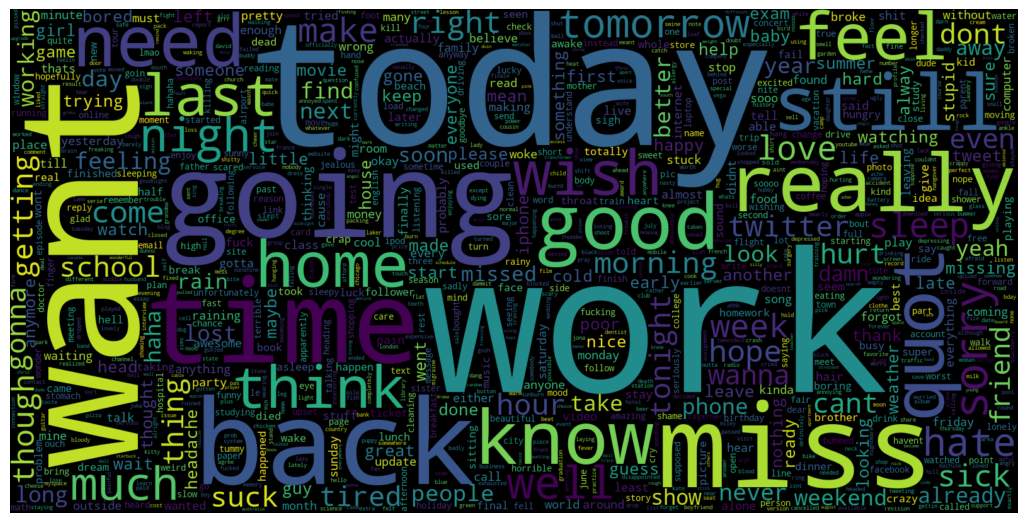

In [24]:
#neg

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==0]])

wordcloud = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(all_words)

# plot the graph
plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

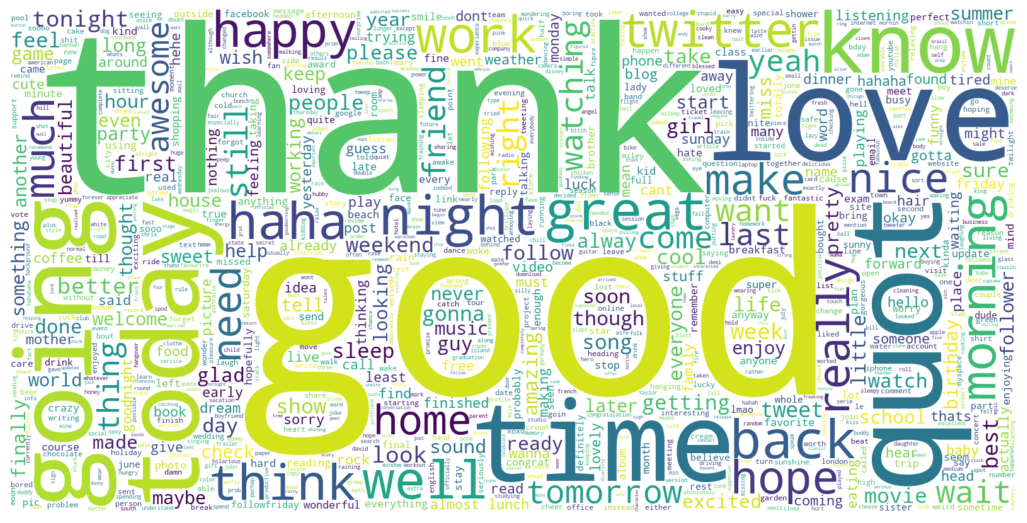

In [25]:
#pos
all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==1]])

wordcloud = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False,background_color = 'white').generate(all_words)

# plot the graph
plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# model training

In [26]:
from sklearn.model_selection import train_test_split
x = dataset['text']
y = dataset['target']

In [27]:
x.size

1600000

In [ ]:
from gensim.models import Word2Vec

word2vec = Word2Vec(x, min_count=2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(, y,  test_size=0.2,random_state=2)

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
#vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=1500)
#vectoriser.fit(x_train)


# Model Fitting


1.MultinomialNB Model 

2.LogisticRegression

3.LinearSVC

In [31]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.69      0.72    160041
           1       0.71      0.77      0.74    159959

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



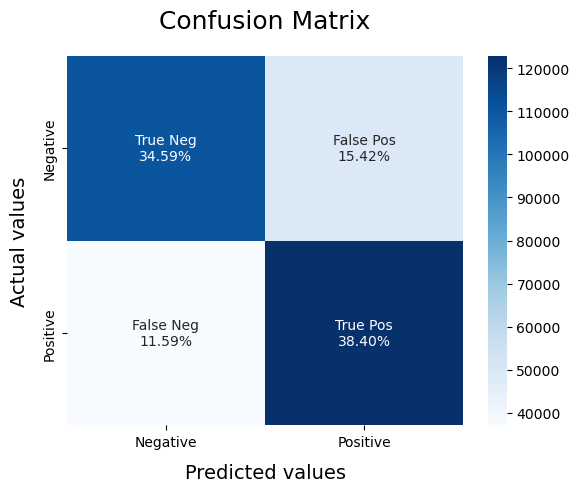

In [32]:
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(x_train, y_train)
acc_BNB= model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.76      0.69      0.72    160041
           1       0.72      0.78      0.75    159959

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.73    320000
weighted avg       0.74      0.74      0.73    320000



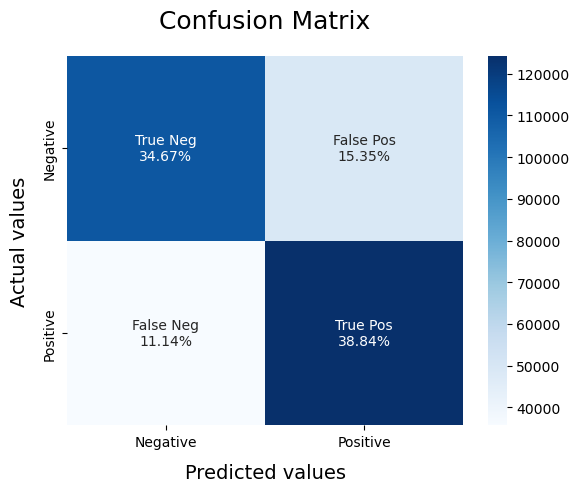

In [33]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
acc_SVC= model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73    160041
           1       0.72      0.78      0.75    159959

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



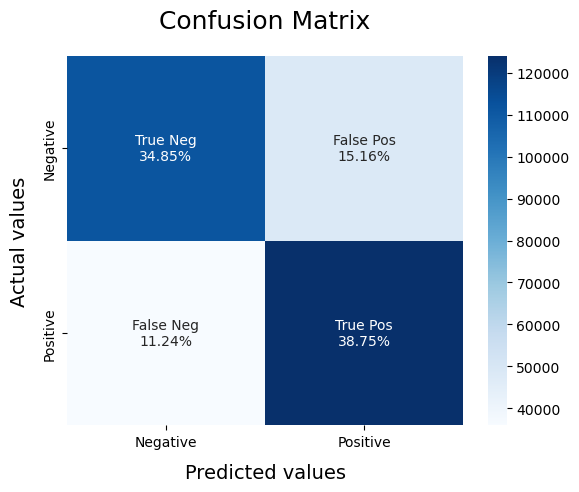

In [34]:
LRmodel = LogisticRegression(C = 1, max_iter = 10000, n_jobs=5)
LRmodel.fit(x_train, y_train)
acc_LR= model_Evaluate(LRmodel)

In [35]:
from sklearn import svm